###  Devanagari Handwritten data set contains 78,000 train images of hindi characters and 18,000 test images 

### These data stored in folders first we need to collect that data from folders and make a single data file

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import pickle

#  next cell take a time be patience

# Preprocessing

In [3]:
path = '../../DataSets/DevanagariHandwrittenCharacterDataset/Train/*'
train_l = []
train_d = [] # pixels 32*32
for label ,folder_name in enumerate(glob.glob(path)):
    for image in (glob.glob(folder_name+'/*')):
        imgdata = plt.imread(image).ravel()  # return (1024,) array  
        train_d.append(imgdata)
        train_l.append(label)
# takes 20 sec

In [4]:
path = '../../DataSets/DevanagariHandwrittenCharacterDataset/Test/*'
test_l = []
test_d = [] # pixels 32*32
for label ,folder_name in enumerate(glob.glob(path)):
    for image in (glob.glob(folder_name+'/*')):
        imgdata = plt.imread(image).ravel()  # return (1024,) array  
        test_d.append(imgdata)
        test_l.append(label)
# takes 10 sec

In [5]:
train_data = np.vstack(train_d)
train_label = np.vstack(train_l)
print(train_data.shape)
print(train_label.shape)

(78200, 1024)
(78200, 1)


In [7]:
test_data = np.vstack(test_d)
test_label = np.vstack(test_l)
del train_d , train_l , test_d , test_l  # free memory
print(test_data.shape)
print(test_label.shape)

NameError: name 'test_d' is not defined

In [ ]:
plt.imshow(train_data[4582,:].reshape(32,32))
plt.show()

In [ ]:
for i in range(1,9):
    plt.subplot(240+i)
    plt.axis('off')
    plt.imshow(train_data[4581+i,:].reshape(32,32), cmap='gray')
plt.show()

In [ ]:
from collections import Counter
print(Counter(train_label[:,0]),end='\n\n')
print(Counter(test_label[:,0]))

In [ ]:
print(np.max(train_data))  # data is already normalized
print(train_data[0,:].tolist())

# lets save this data for future use.

In [ ]:
path = '../../DataSets/DevanagariHandwrittenCharacterDataset/'

#np.savetxt(path+'train_data.csv', train_data, delimiter=",",dtype=)
#np.savetxt(path+'train_labels.csv', train_label, delimiter=",")
#np.savetxt(path+'test_data.csv', test_data, delimiter=",")
#np.savetxt(path+'test_label.csv', test_label, delimiter=",")


# We use ANN to predict the label of each characters

In [8]:
# check total labels
labels = np.unique(train_label).size
labels

46

In [60]:
class NeuralNetwork():
    
    def __init__(self):
        
        self.layers_n       = []
        self.theta_layers   = []
        self.bias           = []
        self.activation_func= []
        self.activations    = []
        self.dL_dA          = []
        self.dL_dtheta      = []
        self.dL_dbias       = []
        self.itera          = []
        self.csfun          = []
                
    def add(self , neuron , activation_function = 'relu'):
        '''You have to give the no. of neurons you want to given layer.
            First layer neurons = no. of columns of your data
            
            default activation function is 'relu' you can change to 'sigmoid' , 'softmax' also
        '''
        self.layers_n.append(neuron)
        
        if activation_function == 'sigmoid' or activation_function == 'relu' or activation_function == 'softmax':
            self.activation_func.append(activation_function)
        else:
            raise TypeError('Pass only relu or sigmoid , and softmax for last layer')
    
    def one_hot_label(self , y):
        one_hot_labels = np.zeros((y.shape[0] , self.layers_n[-1]))
        for i in range(y.shape[0]):  
            one_hot_labels[i, y[i] ] = 1
        return one_hot_labels
    
    def fit(self , X , y , batch_size = 128 , alpha = 0.01 , epoche = 100,lmda = .01):
        for i in range(len(self.layers_n)-1): 
            self.theta_layers.append(np.random.randn(self.layers_n[i],self.layers_n[i+1]))
            
            self.bias.append((np.random.randn(self.layers_n[i+1])))
        
        return self.gradientDecent( X , y , batch_size , alpha , epoche )
    
    def softmax(self , activation , theta , bias):
        exp = np.exp( np.dot( activation , theta ) + bias)
        denominator = np.sum( exp , axis = 1)
        s = list(map(lambda i : exp[:,i] / denominator , np.arange(self.layers_n[-1])))
        return np.array(s).T
    
    def relu(self,activation,theta, bias):
        q = (np.dot(activation , theta) + bias)
        return np.clip(q , a_min=0 , a_max = q)
    
    def sigmoid(self, activation , theta , bias):
        return  1 / (1 + np.exp(np.dot(activation , theta) +  bias))
    
    def forwardPropagation(self,X):
        
        self.activations    = []
        
        self.activations.append(X)
        for i in range(len(self.layers_n)-2):
            self.activations.append(self.relu(self.activations[i] , self.theta_layers[i] , self.bias[i]))
                      
        self.activations.append(self.softmax(self.activations[-1] , self.theta_layers[-1] , self.bias[-1]))
        
    def costFunction(self,X,y):
        
        self.y = self.one_hot_label(y)
        self.forwardPropagation(X)
        
        np.nan_to_num(self.activations[-1] , copy = False)
        self.crossEntropy = self.y * np.log(self.activations[-1])
        np.nan_to_num(self.crossEntropy, copy=False)
        
        #regu = self.lmda * (np.sum(self.theta_layer1)**2 + np.sum(self.theta_layer2)**2 + np.sum(self.theta_layer3)**2 + np.sum(self.theta_layer4)**2)
        return (1/X.shape[0] * -np.sum(self.crossEntropy)) #+ regu  # regu = 0 bcz lmda is zero 
      
    
    def costFunctionDerivative(self,X,y,alpha):
        
        self.dL_dA          = []
        self.dL_dtheta      = []
        self.dL_dbias       = []
        
        self.forwardPropagation(X)
        
        self.y_cap = self.activations[-1]
        self.target_y = self.one_hot_label(y)
        
        self.dL_dA.append(self.y_cap - self.target_y)
        
        for i in range(len(self.layers_n)-2):   
            
            self.dL_dA.append( np.dot( self.dL_dA[i] , self.theta_layers[-1-i].T ) )
        
        for i in range(len(self.layers_n)-1):  
            
            # Storing derivative in a list
            self.dL_dtheta.append(1/X.shape[0] * (np.dot(self.activations[-2-i].T , self.dL_dA[i]))) 
            self.dL_dbias.append(1/X.shape[0] * self.dL_dA[i])
        
        for i in range(len(self.layers_n)-1):  
            
            # updating parameters
            self.theta_layers[i]    -= (alpha * self.dL_dtheta[-1-i])  
            self.bias[-1-i]         -= (alpha * self.dL_dbias[i].sum(axis = 0))                  
            
            # dont get confuse by [-1-i] . Actually derivative are calculated during backpropagation
            # and original values are initialized during forward propagation so derivative are stored in
            # reverse order while data's stored in forward order
      
    def gradientDecent(self , X , y , batch , alpha , epoche  ):
        i = 1
        while i < epoche:
            
            index = np.random.randint(0 , X.shape[0] , size=(batch,))
        
            initial_cost = self.costFunction(X[index] , y[index] )
       
            self.costFunctionDerivative(X[index], y[index],alpha )
        
            #final_cost = self.costFunction(X[index] , y[index])
            
            print('Iteration {} Cost function {}'.format(i , initial_cost ))    
        
            self.itera.append(i)
            self.csfun.append(initial_cost)
            i+=1
            
        final_cost = self.costFunction(X[index] , y[index] )
        self.itera.append(i)
        self.csfun.append(final_cost)
            
        
            
    def gradient_plot(self):
        plt.plot(self.itera[10:],self.csfun[10:])
         
        
    def accuracy(self , X , y):
        self.forwardPropagation(X)
        pred = np.argmax(self.activations[-1],axis=1)
        c1 = 0
        for i,j in enumerate(y):
            if j == pred[i]:
                c1+=1
        print("Accuracy : ",(c1/y.shape[0])*100,'%')    


In [66]:
NN = NeuralNetwork()
NN.add(1024)
NN.add(200)
NN.add(46)
NN.fit(train_data,train_label,alpha=0.099,epoche = 4000,batch_size = 2000)

C:\Users\GirrajJangid\Anaconda3\envs\python_gpu\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log
C:\Users\GirrajJangid\Anaconda3\envs\python_gpu\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in multiply


Iteration 1 Cost function inf
Iteration 2 Cost function 247.51624223704297
Iteration 3 Cost function 8.988465674311578e+304
Iteration 4 Cost function 178.57375081633742
Iteration 5 Cost function 163.91574793470255
Iteration 6 Cost function 153.10433499664487
Iteration 7 Cost function 147.98614205488153
Iteration 8 Cost function 140.79129717380553
Iteration 9 Cost function 135.62904317997268
Iteration 10 Cost function 128.87302185031507
Iteration 11 Cost function 126.07233950284221
Iteration 12 Cost function 122.44857641088538
Iteration 13 Cost function 114.75428177331182
Iteration 14 Cost function 111.98996890473686
Iteration 15 Cost function 107.49830294393175
Iteration 16 Cost function 103.72728227914682
Iteration 17 Cost function 105.27494623806487
Iteration 18 Cost function 97.17962307272248
Iteration 19 Cost function 95.08118752031558
Iteration 20 Cost function 94.36832864135589
Iteration 21 Cost function 92.52375246070078
Iteration 22 Cost function 88.0035917735293
Iteration 23 C

Iteration 181 Cost function 30.92693032762996
Iteration 182 Cost function 29.988292633749605
Iteration 183 Cost function 29.723210298246432
Iteration 184 Cost function 30.016040621224352
Iteration 185 Cost function 30.998452445927438
Iteration 186 Cost function 29.563337828980938
Iteration 187 Cost function 28.651580258651318
Iteration 188 Cost function 28.705575573036587
Iteration 189 Cost function 29.04754443862805
Iteration 190 Cost function 27.070933200835217
Iteration 191 Cost function 28.965730682044107
Iteration 192 Cost function 29.119530992636875
Iteration 193 Cost function 29.48296608746654
Iteration 194 Cost function 26.693597859353325
Iteration 195 Cost function 28.598960031621093
Iteration 196 Cost function 28.453677255357206
Iteration 197 Cost function 28.17379944604897
Iteration 198 Cost function 30.143238106553827
Iteration 199 Cost function 26.18832152373176
Iteration 200 Cost function 27.434866071638474
Iteration 201 Cost function 28.13324275115686
Iteration 202 Cost 

Iteration 357 Cost function 20.406178691750295
Iteration 358 Cost function 21.40998800575095
Iteration 359 Cost function 21.066880951262974
Iteration 360 Cost function 21.17871297433679
Iteration 361 Cost function 20.77802764308997
Iteration 362 Cost function 21.943394333579793
Iteration 363 Cost function 18.872891656810484
Iteration 364 Cost function 20.485272624365113
Iteration 365 Cost function 20.8341138886448
Iteration 366 Cost function 20.703134536427964
Iteration 367 Cost function 21.431217059855257
Iteration 368 Cost function 19.98408250552768
Iteration 369 Cost function 20.020836696787207
Iteration 370 Cost function 21.900039372545493
Iteration 371 Cost function 20.053672227862688
Iteration 372 Cost function 20.148859498333994
Iteration 373 Cost function 19.951716470244254
Iteration 374 Cost function 20.088458011646296
Iteration 375 Cost function 20.670070742425096
Iteration 376 Cost function 20.905186187829408
Iteration 377 Cost function 21.06036450232236
Iteration 378 Cost f

Iteration 533 Cost function 17.390254618612108
Iteration 534 Cost function 17.29008410311183
Iteration 535 Cost function 15.954188340395296
Iteration 536 Cost function 17.995917960707118
Iteration 537 Cost function 16.13368822312728
Iteration 538 Cost function 16.73034405801539
Iteration 539 Cost function 17.248448906706813
Iteration 540 Cost function 17.528771062718135
Iteration 541 Cost function 16.35223125296695
Iteration 542 Cost function 17.611142316147554
Iteration 543 Cost function 16.548656666694892
Iteration 544 Cost function 17.000624981434186
Iteration 545 Cost function 15.274213751182495
Iteration 546 Cost function 16.50436975855149
Iteration 547 Cost function 17.126143851292202
Iteration 548 Cost function 15.566140743910717
Iteration 549 Cost function 16.070454154569546
Iteration 550 Cost function 15.15613679906087
Iteration 551 Cost function 17.202907188642293
Iteration 552 Cost function 15.31281962300548
Iteration 553 Cost function 16.131193191960463
Iteration 554 Cost f

Iteration 710 Cost function 14.981391261367806
Iteration 711 Cost function 14.173238024418346
Iteration 712 Cost function 13.477917861456623
Iteration 713 Cost function 13.19859322606626
Iteration 714 Cost function 13.396240900397384
Iteration 715 Cost function 13.536324953443042
Iteration 716 Cost function 14.220756138151904
Iteration 717 Cost function 13.703568746835696
Iteration 718 Cost function 13.829634591169743
Iteration 719 Cost function 12.552969097255776
Iteration 720 Cost function 12.908625842348519
Iteration 721 Cost function 14.111726007567555
Iteration 722 Cost function 13.818046863128572
Iteration 723 Cost function 13.417675141202464
Iteration 724 Cost function 13.570662122065496
Iteration 725 Cost function 14.070911795063365
Iteration 726 Cost function 13.516566113160442
Iteration 727 Cost function 12.434569647907832
Iteration 728 Cost function 12.821397326265737
Iteration 729 Cost function 14.451622369785362
Iteration 730 Cost function 13.528982869468377
Iteration 731 

Iteration 885 Cost function 12.037385119075525
Iteration 886 Cost function 11.547582046778638
Iteration 887 Cost function 12.58914585784752
Iteration 888 Cost function 12.610835308460915
Iteration 889 Cost function 10.512238508043087
Iteration 890 Cost function 13.419197568631642
Iteration 891 Cost function 12.186390590359457
Iteration 892 Cost function 11.244591291645998
Iteration 893 Cost function 11.641932911058225
Iteration 894 Cost function 12.28186273744053
Iteration 895 Cost function 11.929042473211004
Iteration 896 Cost function 11.25334603186513
Iteration 897 Cost function 11.864640422234777
Iteration 898 Cost function 12.63399352426722
Iteration 899 Cost function 11.589983810590013
Iteration 900 Cost function 12.244504089044788
Iteration 901 Cost function 12.370112389536532
Iteration 902 Cost function 11.54444367104369
Iteration 903 Cost function 10.539178771544705
Iteration 904 Cost function 11.94167625842469
Iteration 905 Cost function 11.445316077391245
Iteration 906 Cost 

Iteration 1060 Cost function 10.11608892160151
Iteration 1061 Cost function 10.070783074407778
Iteration 1062 Cost function 9.79794059999898
Iteration 1063 Cost function 9.927161713563628
Iteration 1064 Cost function 10.270588622237453
Iteration 1065 Cost function 11.188231438564355
Iteration 1066 Cost function 9.38152978472518
Iteration 1067 Cost function 10.360856410735435
Iteration 1068 Cost function 10.05858760310976
Iteration 1069 Cost function 10.488936048911244
Iteration 1070 Cost function 9.940198064164457
Iteration 1071 Cost function 9.337130789917584
Iteration 1072 Cost function 9.872517494713644
Iteration 1073 Cost function 10.573671839890935
Iteration 1074 Cost function 9.83993709570139
Iteration 1075 Cost function 9.877678401062628
Iteration 1076 Cost function 10.19831729608679
Iteration 1077 Cost function 10.619239072793707
Iteration 1078 Cost function 9.671745773632066
Iteration 1079 Cost function 9.965362379604795
Iteration 1080 Cost function 9.438438600773873
Iteration

Iteration 1235 Cost function 8.935480638836554
Iteration 1236 Cost function 7.8487441581624555
Iteration 1237 Cost function 8.536321138508352
Iteration 1238 Cost function 8.55052424912403
Iteration 1239 Cost function 8.842185470573654
Iteration 1240 Cost function 8.807051258820747
Iteration 1241 Cost function 8.603034704031208
Iteration 1242 Cost function 8.944919735135802
Iteration 1243 Cost function 9.663628906156553
Iteration 1244 Cost function 9.150317717988722
Iteration 1245 Cost function 9.060975913923151
Iteration 1246 Cost function 9.014321722118133
Iteration 1247 Cost function 9.466259128238793
Iteration 1248 Cost function 8.810937575056842
Iteration 1249 Cost function 8.479123895593078
Iteration 1250 Cost function 8.245441245433566
Iteration 1251 Cost function 8.918150981103745
Iteration 1252 Cost function 8.311806004474251
Iteration 1253 Cost function 8.671956102351892
Iteration 1254 Cost function 9.097234078498566
Iteration 1255 Cost function 8.567135065236311
Iteration 125

Iteration 1410 Cost function 7.713138549058147
Iteration 1411 Cost function 8.35576348637441
Iteration 1412 Cost function 7.728180195062887
Iteration 1413 Cost function 8.427386569263506
Iteration 1414 Cost function 8.082356138062709
Iteration 1415 Cost function 8.35826639114575
Iteration 1416 Cost function 7.693841073687716
Iteration 1417 Cost function 7.61079743945052
Iteration 1418 Cost function 7.786622208610771
Iteration 1419 Cost function 8.153935391525321
Iteration 1420 Cost function 8.007029661320678
Iteration 1421 Cost function 7.493681016264694
Iteration 1422 Cost function 7.699194598007422
Iteration 1423 Cost function 8.138069338558482
Iteration 1424 Cost function 7.681169465783401
Iteration 1425 Cost function 7.844769571796888
Iteration 1426 Cost function 7.0156883330086375
Iteration 1427 Cost function 7.590490621077082
Iteration 1428 Cost function 7.905042396007535
Iteration 1429 Cost function 7.152442929305644
Iteration 1430 Cost function 7.407175909284008
Iteration 1431 

Iteration 1585 Cost function 7.0612370467853
Iteration 1586 Cost function 7.169754012758245
Iteration 1587 Cost function 7.219764236211723
Iteration 1588 Cost function 6.838772116360673
Iteration 1589 Cost function 7.501753065943704
Iteration 1590 Cost function 6.887070512773089
Iteration 1591 Cost function 7.648164625453635
Iteration 1592 Cost function 6.917448430086398
Iteration 1593 Cost function 7.481989873731368
Iteration 1594 Cost function 7.284615051133677
Iteration 1595 Cost function 6.9272610895208055
Iteration 1596 Cost function 7.4516128696687325
Iteration 1597 Cost function 6.7858397607368905
Iteration 1598 Cost function 7.184553866494723
Iteration 1599 Cost function 6.675530614309355
Iteration 1600 Cost function 6.462357032209739
Iteration 1601 Cost function 6.850225253280052
Iteration 1602 Cost function 7.1670367261960415
Iteration 1603 Cost function 6.780786205186304
Iteration 1604 Cost function 6.741392852458535
Iteration 1605 Cost function 7.514633797060946
Iteration 1

Iteration 1759 Cost function 6.829563193030375
Iteration 1760 Cost function 6.5866824985853265
Iteration 1761 Cost function 6.174089031079955
Iteration 1762 Cost function 6.132748131938522
Iteration 1763 Cost function 5.620270489397844
Iteration 1764 Cost function 6.307875187689431
Iteration 1765 Cost function 6.1738406589816295
Iteration 1766 Cost function 6.3352103722553315
Iteration 1767 Cost function 6.040369030941807
Iteration 1768 Cost function 6.192701785958247
Iteration 1769 Cost function 6.733872686687978
Iteration 1770 Cost function 6.999766482070228
Iteration 1771 Cost function 5.916244322248119
Iteration 1772 Cost function 6.080840515877795
Iteration 1773 Cost function 6.169051731585522
Iteration 1774 Cost function 6.498952267511498
Iteration 1775 Cost function 5.875995434187353
Iteration 1776 Cost function 5.899711462368734
Iteration 1777 Cost function 6.3326674402970005
Iteration 1778 Cost function 6.031377283799117
Iteration 1779 Cost function 6.483647233827346
Iteration

Iteration 2108 Cost function 5.1366221093563755
Iteration 2109 Cost function 4.920280375947426
Iteration 2110 Cost function 4.76903556894147
Iteration 2111 Cost function 5.6268181169529985
Iteration 2112 Cost function 5.023663138253739
Iteration 2113 Cost function 5.511904746776127
Iteration 2114 Cost function 5.516477231947178
Iteration 2115 Cost function 4.846940933334305
Iteration 2116 Cost function 5.588717083863385
Iteration 2117 Cost function 5.353414942495343
Iteration 2118 Cost function 5.506214252000127
Iteration 2119 Cost function 4.8932291737043085
Iteration 2120 Cost function 4.9855392598012305
Iteration 2121 Cost function 5.24507117898112
Iteration 2122 Cost function 5.054738345405642
Iteration 2123 Cost function 5.42833678045681
Iteration 2124 Cost function 5.068109114572997
Iteration 2125 Cost function 5.133059469070816
Iteration 2126 Cost function 5.554071100548714
Iteration 2127 Cost function 5.420110520500558
Iteration 2128 Cost function 5.096490469088925
Iteration 21

Iteration 2457 Cost function 4.067634898806601
Iteration 2458 Cost function 4.157088150914901
Iteration 2459 Cost function 4.183571538355659
Iteration 2460 Cost function 4.182759652013886
Iteration 2461 Cost function 4.195161255910949
Iteration 2462 Cost function 4.512061497358635
Iteration 2463 Cost function 4.006619585566992
Iteration 2464 Cost function 4.160057776269114
Iteration 2465 Cost function 4.460800911168255
Iteration 2466 Cost function 4.375633853209308
Iteration 2467 Cost function 4.343353298692179
Iteration 2468 Cost function 4.545243555481763
Iteration 2469 Cost function 4.513869415976833
Iteration 2470 Cost function 4.726486874373892
Iteration 2471 Cost function 4.404543501168594
Iteration 2472 Cost function 4.113613847805667
Iteration 2473 Cost function 4.467625730611746
Iteration 2474 Cost function 4.499929808909052
Iteration 2475 Cost function 4.605966200823401
Iteration 2476 Cost function 4.0891288749936985
Iteration 2477 Cost function 4.318204927343408
Iteration 24

Iteration 2631 Cost function 4.43351643072927
Iteration 2632 Cost function 4.209727043065708
Iteration 2633 Cost function 4.597461394367063
Iteration 2634 Cost function 4.497780664316715
Iteration 2635 Cost function 4.005258166830215
Iteration 2636 Cost function 3.682367174783604
Iteration 2637 Cost function 4.023802822518177
Iteration 2638 Cost function 4.510570576771563
Iteration 2639 Cost function 4.220176720165243
Iteration 2640 Cost function 4.346771771917563
Iteration 2641 Cost function 4.307072511237407
Iteration 2642 Cost function 4.10154726467843
Iteration 2643 Cost function 4.23924267159357
Iteration 2644 Cost function 3.976206235348585
Iteration 2645 Cost function 3.939750686619567
Iteration 2646 Cost function 4.259247601015504
Iteration 2647 Cost function 4.085053935496168
Iteration 2648 Cost function 3.9958249498136786
Iteration 2649 Cost function 3.8839955598905416
Iteration 2650 Cost function 3.8374145994336493
Iteration 2651 Cost function 3.80220913317305
Iteration 2652

Iteration 2805 Cost function 3.7695772080102747
Iteration 2806 Cost function 3.7940591119545584
Iteration 2807 Cost function 3.9864855990749963
Iteration 2808 Cost function 3.7189844719960323
Iteration 2809 Cost function 3.687361372407688
Iteration 2810 Cost function 3.8641088845632545
Iteration 2811 Cost function 3.844960001165437
Iteration 2812 Cost function 3.827264949199853
Iteration 2813 Cost function 4.076964688040764
Iteration 2814 Cost function 3.66071161352968
Iteration 2815 Cost function 3.385685648110733
Iteration 2816 Cost function 3.699288158698629
Iteration 2817 Cost function 3.461498396607077
Iteration 2818 Cost function 3.720841003440754
Iteration 2819 Cost function 3.8900103584313737
Iteration 2820 Cost function 3.5078329360560954
Iteration 2821 Cost function 3.71406411154899
Iteration 2822 Cost function 3.653118433344282
Iteration 2823 Cost function 3.5151331963710204
Iteration 2824 Cost function 3.8924509514990993
Iteration 2825 Cost function 3.5391698688671664
Itera

Iteration 2978 Cost function 3.707165351606945
Iteration 2979 Cost function 3.2328716101740476
Iteration 2980 Cost function 3.339165259254192
Iteration 2981 Cost function 3.378249606436965
Iteration 2982 Cost function 3.346482691746252
Iteration 2983 Cost function 3.129959121781106
Iteration 2984 Cost function 3.912374655291334
Iteration 2985 Cost function 3.4312807250047066
Iteration 2986 Cost function 3.6867726096702103
Iteration 2987 Cost function 3.332304943523598
Iteration 2988 Cost function 3.4031054471849838
Iteration 2989 Cost function 3.2014004014773696
Iteration 2990 Cost function 3.4638177166739323
Iteration 2991 Cost function 3.2699864900930713
Iteration 2992 Cost function 3.495437509560081
Iteration 2993 Cost function 3.3581042574724123
Iteration 2994 Cost function 3.477546067455628
Iteration 2995 Cost function 3.1469146438388718
Iteration 2996 Cost function 3.6541559239476338
Iteration 2997 Cost function 3.567383201298576
Iteration 2998 Cost function 3.3482183671898342
It

Iteration 3151 Cost function 3.060831975160751
Iteration 3152 Cost function 3.1888038924430737
Iteration 3153 Cost function 3.368352546226116
Iteration 3154 Cost function 3.461621105916737
Iteration 3155 Cost function 3.169746808192012
Iteration 3156 Cost function 2.9518269134734205
Iteration 3157 Cost function 3.1353165526546443
Iteration 3158 Cost function 3.417376500464082
Iteration 3159 Cost function 2.9290924905415583
Iteration 3160 Cost function 3.5091924381374
Iteration 3161 Cost function 3.152250086032777
Iteration 3162 Cost function 2.8719786709142405
Iteration 3163 Cost function 3.754353004998665
Iteration 3164 Cost function 3.3949364072565564
Iteration 3165 Cost function 3.1620963641170157
Iteration 3166 Cost function 3.4187078400898376
Iteration 3167 Cost function 3.104422383126815
Iteration 3168 Cost function 3.4505320779617015
Iteration 3169 Cost function 3.048817355048996
Iteration 3170 Cost function 3.1932356297856255
Iteration 3171 Cost function 3.1185574137085834
Iter

Iteration 3324 Cost function 3.1393018143745826
Iteration 3325 Cost function 2.563141797124634
Iteration 3326 Cost function 2.950457515484895
Iteration 3327 Cost function 3.0327552966738183
Iteration 3328 Cost function 2.658541413398171
Iteration 3329 Cost function 2.599806953115018
Iteration 3330 Cost function 2.9536096266894494
Iteration 3331 Cost function 3.0839344364288266
Iteration 3332 Cost function 2.9612943011544237
Iteration 3333 Cost function 3.005369827327308
Iteration 3334 Cost function 2.726556607043484
Iteration 3335 Cost function 2.958633771380953
Iteration 3336 Cost function 2.856772850916518
Iteration 3337 Cost function 2.966777718619797
Iteration 3338 Cost function 3.1314968680237314
Iteration 3339 Cost function 2.937378803146189
Iteration 3340 Cost function 2.77744741011574
Iteration 3341 Cost function 2.9573162046929222
Iteration 3342 Cost function 2.9415154433167925
Iteration 3343 Cost function 3.0557109161701925
Iteration 3344 Cost function 2.905835399896507
Itera

Iteration 3497 Cost function 2.3512285486813607
Iteration 3498 Cost function 2.9970749590032306
Iteration 3499 Cost function 2.7661686705399333
Iteration 3500 Cost function 2.8325179342359146
Iteration 3501 Cost function 2.548401093953749
Iteration 3502 Cost function 3.021073900772751
Iteration 3503 Cost function 3.0748108508265544
Iteration 3504 Cost function 3.13713723547787
Iteration 3505 Cost function 2.7501281990110114
Iteration 3506 Cost function 3.2140353812149525
Iteration 3507 Cost function 2.916420556713074
Iteration 3508 Cost function 2.9512273551476103
Iteration 3509 Cost function 2.7432011831076077
Iteration 3510 Cost function 2.6160837409095885
Iteration 3511 Cost function 2.772129014596501
Iteration 3512 Cost function 2.811931210576673
Iteration 3513 Cost function 2.7764229416924198
Iteration 3514 Cost function 2.688557176856183
Iteration 3515 Cost function 2.9905093082993304
Iteration 3516 Cost function 2.922605148204745
Iteration 3517 Cost function 2.9106189416784365
I

Iteration 3842 Cost function 2.2820148472113497
Iteration 3843 Cost function 2.3072241059780914
Iteration 3844 Cost function 2.3197988217478964
Iteration 3845 Cost function 2.4937945686498817
Iteration 3846 Cost function 2.7511989098504723
Iteration 3847 Cost function 2.4828632014107113
Iteration 3848 Cost function 2.3226111404000434
Iteration 3849 Cost function 2.5014664763262564
Iteration 3850 Cost function 2.136133460731088
Iteration 3851 Cost function 2.4877815767313654
Iteration 3852 Cost function 2.459105656293739
Iteration 3853 Cost function 2.8945510036114848
Iteration 3854 Cost function 2.5341548821274356
Iteration 3855 Cost function 2.2737862239793607
Iteration 3856 Cost function 2.512798896741228
Iteration 3857 Cost function 2.5452023192340003
Iteration 3858 Cost function 2.5037365944404506
Iteration 3859 Cost function 2.501185603845534
Iteration 3860 Cost function 2.3409210084688663
Iteration 3861 Cost function 2.5225186920610834
Iteration 3862 Cost function 2.6489490422572

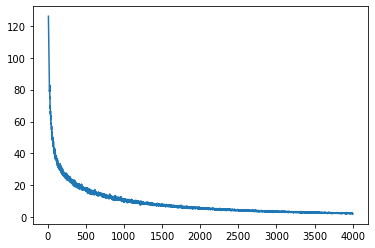

In [67]:
NN.gradient_plot()

In [70]:
NN.accuracy(train_data,train_label)
NN.accuracy(test_data,test_label)

Accuracy :  72.34526854219949 %
Accuracy :  69.73188405797102 %


In [69]:
with open('../../DataSets/Objects/ANN_devanagari_scratch.pkl', 'wb') as output:
    pickle.dump(NN, output, pickle.HIGHEST_PROTOCOL)

del NN

with open('../../DataSets/Objects/ANN_devanagari_scratch.pkl', 'rb') as inpt:
    NN = pickle.load(inpt)
